#### Quick attempt at implementing Toroidal Diffusions

Some helper functions

In [1]:
# map x to (-œÄ, œÄ]
cmod(x::Real) = rem2pi(x, RoundNearest);

# returns [-r,r]·µà ‚äÇ ‚Ñ§·µà
hyper_cube(r::Int, d::Int) = map(collect, vec(collect(Base.product(fill(-r:r, d)...))));

# returns 2œÄ[-r,r]·µà ‚äÇ 2œÄ‚Ñ§·µà
twoœÄ_hyper_cube(r::Int, d::Int) = 2œÄ .* hyper_cube(r, d);

Define a Wrapped Normal distribution

In [2]:
using PDMats, Distributions

export 
struct WrappedMvNormal{T <: Real,
                       Cov <: AbstractPDMat{T},
                       Mean <: AbstractVector{T}
                       } <: ContinuousMultivariateDistribution 
    
    ùõ∑::MvNormal{T, Cov, Mean}      # the underlying unwrapped distribution
    ùïÉ::Vector{Vector{T}}           # ùïÉ ‚äÇ 2œÄ‚Ñ§·µà truncated period lattice considered for computing the pdf
end


# Constructors

function WrappedMvNormal(Œº::AbstractVector{T}, Œ£::AbstractPDMat{T}, max_k=2) where T <: Real
    WrappedMvNormal{T, typeof(Œ£), typeof(Œº)}(MvNormal(Œº, Œ£), twoœÄ_hyper_cube(max_k, length(Œº)))
end

function WrappedMvNormal(Œº::AbstractVector{<:Real}, Œ£::AbstractPDMat{<:Real}, max_k=2)
    R = Base.promote_eltype(Œº, Œ£)
    WrappedMvNormal(convert(AbstractArray{R}, Œº), convert(AbstractArray{R}, Œ£), max_k)
end

WrappedMvNormal(Œº::AbstractVector{<:Real}, Œ£::AbstractMatrix{<:Real}, max_k=2) = WrappedMvNormal(Œº, PDMat(Œ£), max_k);



# Methods

using Random, LogExpFunctions
import Base: length, eltype
import Distributions: pdf, logpdf, mean, _rand!

length(d::WrappedMvNormal) = length(d.ùõ∑);

eltype(d::WrappedMvNormal) = eltype(d.ùõ∑);

_rand!(rng::AbstractRNG, d::WrappedMvNormal, x::AbstractArray{<:Real}) =
    cmod.(_rand!(rng, d.ùõ∑, x))

function pdf(d::WrappedMvNormal, x::AbstractVector)
    Œ∏ = cmod.(x)
    sum(pdf.(Ref(d.ùõ∑), Ref(Œ∏) .+ d.ùïÉ))
end

function logpdf(d::WrappedMvNormal, x::AbstractVector) 
    Œ∏ = cmod.(x)
    logsumexp(logpdf.(Ref(d.ùõ∑), Ref(Œ∏) .+ d.ùïÉ)); # Ref stops arguments from being broadcasted
end

mean(d::WrappedMvNormal) = mean(d.ùõ∑);
    
function plotpdf(d::WrappedMvNormal, step=0.05)
    Z = [pdf(d,[j,i]) for i in -œÄ:step:œÄ, j in -œÄ:step:œÄ]
    heatmap(-œÄ:step:œÄ, -œÄ:step:œÄ, Z, size=(400, 400), title="WN Density")
end;

Quick sanity checks

WrappedMvNormal{Float64, PDiagMat{Float64, Vector

{Float64}}, Vector{Float64}}
2
Float64
[2.5, 0.5]


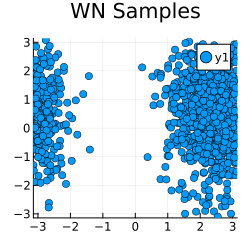

In [5]:
w = WrappedMvNormal([2.5, 0.5], PDiagMat([0.6, 1.5]), 3)

println(typeof(w))

println(length(w))
println(eltype(w))
println(mean(w))

using Plots

samples = rand(w, 1000)
scatter(samples[1, :], samples[2, :], size=(250,250), xlims=(-œÄ, œÄ), ylims=(-œÄ, œÄ), title="WN Samples")

In [ ]:
plotpdf(w)

Now we can begin to define the WN OU diffusion. For that we just need the transition probability distribution, since the process is Markovian. It doesn't have a nice closed form so we use an approximation. 

But first, more helper functions...

In [ ]:
using LinearAlgebra
ùëü(A::AbstractMatrix{<:Real}) = tr(A) / 2;
ùëû(A::AbstractMatrix{<:Real}) = ‚àö(abs(det(A - ùëü(A)I)));
ùëé(t::Real, r::Real, q::Real) = exp(-r*t)*(cosh(q*t) + r * sinh(q*t) / q);
ùëè(t::Real, r::Real, q::Real) = exp(-r*t)*(sinh(q*t) / q);
ùë†(t::Real, r::Real, q::Real) = 1 - ùëé(2t, r, q);
ùëñ(t::Real, r::Real, q::Real) = ùëè(2t, r, q) / 2;

In [ ]:
struct WrappedDiffusion{T <: Real, 
                        Mat <: AbstractMatrix{T},
                        InfCov <: AbstractPDMat{T},
                        StatCov <: AbstractPDMat{T},
                        Mean <: AbstractVector{T}}
    Œº::Mean                                # mean
    Œ£::InfCov                              # infinitesimal covariance
    A::Mat                                 # drift

    _¬ΩA‚Åª¬πŒ£::StatCov                        # stationary covariance
    
    ùïÉ::Vector{Vector{T}}                   # truncated winding lattice
    
    wn_stat::WrappedMvNormal{T, StatCov, Mean} # stationary distribution
    
    r::Real                                # ùëü(A)
    q::Real                                # ùëû(A)
end

In [ ]:

# Constructors 

function WrappedDiffusion(Œº::AbstractVector{T}, Œ£::AbstractPDMat{T}, A::AbstractMatrix{T}, max_k=2) where T <: Real
    _¬ΩA‚Åª¬πŒ£ = PDMat(0.5 * inv(A) * Œ£)
    WrappedDiffusion{T, typeof(A), typeof(Œ£), typeof(_¬ΩA‚Åª¬πŒ£), typeof(Œº)}(Œº, Œ£, A, _¬ΩA‚Åª¬πŒ£, 
                                                                         twoœÄ_hyper_cube(max_k, length(Œº)),
                                                                         WrappedMvNormal(Œº, _¬ΩA‚Åª¬πŒ£, max_k),
                                                                         ùëü(A), ùëû(A))
end

function WrappedDiffusion(Œº::AbstractVector{<:Real}, 
                          Œ£::AbstractPDMat{<:Real}, 
                          A::AbstractMatrix{<:Real}, 
                          max_k=2)
    R = Base.promote_eltype(Œº, Œ£, A)
    WrappedMvNormal(convert(AbstractArray{R}, Œº),
                    convert(AbstractArray{R}, Œ£),
                    convert(AbstractArray{R}, A),
                    max_k)
end

WrappedDiffusion(Œº::AbstractVector{<:Real}, 
                 Œ£::AbstractMatrix{<:Real}, 
                 A::AbstractMatrix{<:Real},
                 max_k=2) = 
    WrappedDiffusion(Œº, PDMat(Œ£), A, max_k)


# Constructor for 2-dimensional drift
# œÉ -- variance coefficient of each angle
# Œ± -- drift coefficient for each angle, as well as their drift covariance
function WrappedDiffusion(Œº::AbstractVector{<:Real}, 
                          œÉ_ùúô::Real, œÉ_ùúì::Real, 
                          Œ±_ùúô::Real, Œ±_ùúì::Real, Œ±_cov::Real, 
                          max_k=2)
    @assert length(Œº) == 2
    @assert Œ±_ùúô * Œ±_ùúì > Œ±_cov^2
    @assert œÉ_ùúô * œÉ_ùúì > 0
    
    Œ£ = PDiagMat([œÉ_ùúô^2, œÉ_ùúì^2])
    A = [Œ±_ùúô (œÉ_ùúô*Œ±_cov/œÉ_ùúì); (œÉ_ùúì*Œ±_cov/œÉ_ùúô) œÉ_ùúì]
    
    WrappedDiffusion(Œº, Œ£, A, max_k)
end


In [ ]:
# Methods

mean(ùöØ::WrappedDiffusion) = ùöØ.Œº

length(ùöØ::WrappedDiffusion) = length(ùöØ.Œº)

weight(ùöØ::WrappedDiffusion, k::AbstractVector{<:Real}, Œ∏::AbstractVector) =
    pdf(ùöØ.wn_stat.ùõ∑, Œ∏ + k) / pdf(ùöØ.wn_stat, Œ∏ + k)


logweight(ùöØ::WrappedDiffusion, k::AbstractVector{<:Real}, Œ∏::AbstractVector) =
    logpdf(ùöØ.wn_stat.ùõ∑, Œ∏ + k) - logpdf(ùöØ.wn_stat, Œ∏ + k)


function Œì_2D(ùöØ::WrappedDiffusion, t::Real)
    @assert t > 0
    ùë†(t, ùöØ.r, ùöØ.q) * ùöØ._¬ΩA‚Åª¬πŒ£ + ùëñ(t, ùöØ.r, ùöØ.q) * ùöØ.Œ£
end

matexp_2D(ùöØ::WrappedDiffusion, t::Real) =
    ùëé(t, ùöØ.r, ùöØ.q) * I + ùëè(t, ùöØ.r, ùöØ.q) * ùöØ.A


function tpd(ùöØ::WrappedDiffusion, t::Real, Œ∏‚ÇÄ::AbstractVector, Œ∏‚Çú::AbstractVector)
    if t < eps(typeof(t)) # if t == 0, distribution degenerates into Dirac(Œ∏‚ÇÄ)
        return Œ∏‚ÇÄ== Œ∏‚Çú
    end
    
    if length(ùöØ) == 2
        Œì‚Çú = Œì_2D(ùöØ, t)
        e‚Åª·µó·¥¨= matexp_2D(ùöØ, t) 
    else
        throw("tpd only implemented for 2 dimensions")
    end
    
    wn_Œì‚Çú= WrappedMvNormal(ùöØ.Œº, Œì‚Çú)
    
    sum(map(m -> pdf(wn_Œì‚Çú, Œ∏‚Çú - e‚Åª·µó·¥¨ * (Œ∏‚ÇÄ - ùöØ.Œº + m)) * weight(ùöØ, m, Œ∏‚Çú), ùöØ.ùïÉ))
end;
    
function logtpd(ùöØ::WrappedDiffusion, t::Real, Œ∏‚ÇÄ::AbstractVector, Œ∏‚Çú::AbstractVector)
    if t < eps(typeof(t)) # if t == 0, distribution degenerates into Dirac(Œ∏‚ÇÄ)
        return log(Œ∏‚ÇÄ== Œ∏‚Çú)
    end
                
    if length(ùöØ) == 2
        Œì‚Çú = Œì_2D(ùöØ, t)
        e‚Åª·µó·¥¨= matexp_2D(ùöØ, t) 
    else
        throw("logtpd only implemented for 2 dimensions")
    end
    
    wn_Œì‚Çú= WrappedMvNormal(ùöØ.Œº, Œì‚Çú)
    
    logsumexp(map(m -> logpdf(wn_Œì‚Çú, Œ∏‚Çú - e‚Åª·µó·¥¨ * (Œ∏‚ÇÄ - ùöØ.Œº + m)) + logweight(ùöØ, m, Œ∏‚Çú), ùöØ.ùïÉ))
end;

In [ ]:
ùöØ = WrappedDiffusion([0.0, 0.0], 1.0, 2.0, 3.0, 5.0, 1.0, 2);

println(log(tpd(ùöØ, 100.4, [1.0, 0.0], [0.0, 0.0])))
println(logtpd(ùöØ, 100.4, [1.0, 0.0], [0.0, 0.0]))
plotpdf(ùöØ.wn_stat)

In [ ]:
Œ∏‚ÇÄ= [-3.0, 3.0]
t_step = 0.2
last = 3.0

times=[0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 30.0, 68.0, 150.0, 300.0]

anim = @animate for t ‚àà times
    println(t)
    Z = [tpd(ùöØ, t, Œ∏‚ÇÄ, [j, i]) for i in -œÄ:0.1:œÄ, j in -œÄ:0.1:œÄ]
    heatmap(-œÄ:0.1:œÄ, -œÄ:0.1:œÄ, Z, size=(400,400), title="TPD t=" * string(t))
end
    
gif(anim, "diffuse.gif", fps=10)